# Coalescent Tree Analysis
## Jose Manuel Ag&uuml;ero Trejo

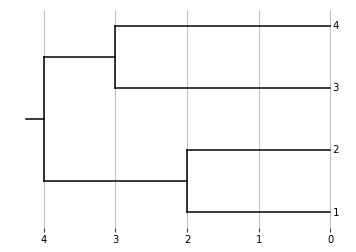

In [1]:
"""
tree69.py
A tree utility library for COMPSCI 369.
"""

# The MIT License (MIT)
#
# Copyright (c) 2016 Arman Bilge and Stuart Bradley
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def compute_upgma_tree(matrix):

    import itertools as it

    n = len(matrix)
    nodes = [Node(str(i + 1)) for i in range(n)]
    for node in nodes:
        node.set_height(0)
    matrix = {nodes[i]: {nodes[j]: matrix[i][j] for j in range(n)} for i in range(n)}
    while len(matrix) > 1:
        a, b = min(it.combinations(matrix.keys(), 2), key=lambda xy: matrix[xy[0]][xy[1]])
        u = Node()
        u.add_child(a)
        u.add_child(b)
        u.set_height(matrix[a][b] / 2)
        uc = {c: (a.get_leaf_count() * matrix[a][c] + b.get_leaf_count() * matrix[b][c]) / (a.get_leaf_count() + b.get_leaf_count()) for c in matrix.keys() - set((a, b))}
        del matrix[a]
        del matrix[b]
        for k, v in matrix.items():
            del v[a]
            del v[b]
            v[u] = uc[k]
        matrix[u] = uc
    return Tree(u)

def plot_tree(tree):

    import itertools as it
    import numpy as np
    from matplotlib import pyplot as plt

    def compute_node_xy(node, counter=it.count()):
        node.x = node.get_height()
        if node.is_leaf():
            node.y = next(counter)
        else:
            children = node.get_children()
            for child in children:
                compute_node_xy(child, counter)
            node.y = np.mean([c.y for c in children])

    def plot_node(node):
        if node.is_leaf():
            plt.text(node.x, node.y, ' ' + node.get_label(), {'ha':'left', 'va':'center'})
        else:
            children = node.get_children()
            plt.plot([node.x] * 2, [min(c.y for c in children), max(c.y for c in children)], 'k')
            for child in children:
                plt.plot([node.x, child.x], [child.y] * 2, 'k')
                plot_node(child)

    root = tree.get_root()
    compute_node_xy(root)
    plt.plot([root.x, root.x + root.x/16], [root.y] * 2, 'k')
    plot_node(root)
    lc = tree.get_leaf_count()
    plt.ylim(- lc / 16, 17/16 * lc - 1)
    axes = plt.gca()
    axes.invert_xaxis()
    axes.yaxis.set_visible(False)
    axes.set_frame_on(False)
    axes.grid()
    plt.show()

"""
Python Tree Class
Stuart Bradley - 5931269
23-05-2014
"""
class Tree:

    def __init__(self, root=None):
        self.root = root

    def set_root(self, root):
        self.root = root

    def get_root(self):
        return self.root

    def get_leaves(self):
        return self.root.get_leaves()

    def get_leaf_count(self):
        return self.root.get_leaf_count()

    def get_newick(self):
        return self.root.get_newick() + ";"

    def __str__(self):
        return self.get_newick()

"""
Python Node Class
Stuart Bradley - 5931269
23-05-2014
"""
class Node:
    def __init__(self, label=None):
        self.parent = None
        self.children = []
        self.height = -1.0
        self.label = label
        self.sequence = None

    def get_parent(self):
        return self.parent

    def set_parent(self, parent):
        self.parent = parent

    def get_children(self):
        return self.children

    def add_child(self, child):
        self.children.append(child)
        child.set_parent(self)

    def remove_child(self, child):
        self.children.remove(child)

    def set_height(self, height):
        self.height = height

    def get_height(self):
        return self.height

    def is_root(self):
        return self.parent == None

    def is_leaf(self):
        return not self.children

    def get_sequence(self):
        return self.sequence

    def set_sequence(self, sequence):
        self.sequence = sequence

    def get_label(self):
        return self.label

    def set_label(self, label):
        self.label = label

    def get_leaves(self):
        leaf_list = []

        if (self.is_leaf()):
            leaf_list.append(self)
        else:
            for child in self.children:
                leaf_list.extend(child.get_leaves())

        return leaf_list

    def get_leaf_count(self):
        if self.is_leaf():
            return 1
        else:
            return sum(map(Node.get_leaf_count, self.children))

    def get_newick(self):
        sb = ""

        if (not self.is_leaf()):
            sb += "("
            for i in range(0, len(self.children)):
                if (i>0):
                    sb += ","
                sb += self.children[i].get_newick()
            sb += ")"

        if (self.label != None):
            sb += self.label

        branch_length = -1.0
        if (not self.is_root()):
            branch_length = self.parent.height - self.height
        else:
            branch_length = 0.0

        sb += ":" + str(branch_length)

        return sb

    
# Calculate the UPGMA tree from the distance matrix
tree = compute_upgma_tree([[0, 4, 8, 8], [4, 0, 8, 8], [8, 8, 0, 6], [8, 8, 6, 0]])

# Plot the tree
plot_tree(tree)

## Tree simulation according to Kingman coalescent model

"The Kingman coalescent model is a lineage death process backwards in time that
provides a simple algorithm for simulating a gene tree of $n$ chromosomes from a
larger population of $N_{e}$ chromosomes."<br> For each leaf a linage is traced from present to past. Eventually this process coalesces to a single ancestor. At each iteration there are $k$ choose $2$ options of pairs that may coalesce with a rate of $1/N_{e}$ per pair. In this model the height of a tree represents the time of coalescence

Mean tree height using Kingsman coalescent model simulation:
188.93732443602818

Theoretical mean tree height for Kingsman coalescent model: 
180.0


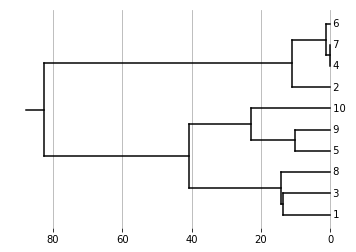

In [2]:
import random
import numpy as np
#This function simulates a tree according to Kingsman coalescent model with
#n = number of leaves and Ne = effective population size and returns a the simulated tree
def kingman_tree(n,ne):
    k = n
    t = 0
    nodes = list()
    #Make n leaf nodes with time t = 0 and labeled from 1 to n. This is the set of available nodes.
    for i in range(n):
        nodes.append(Node(str(i+1)))
        nodes[i].set_height(t)
    while k > 1:
        kc2 = k*(k-1)/2
        tk = np.random.exponential(ne/kc2) #A time sample is generated using the total rate of coalescence.
        t = t + tk
        indices = random.sample(range(len(nodes)),2) #randomly choosing two discting nodes index
        indices.sort()    
        label = nodes[indices[0]].get_label()+nodes[indices[1]].get_label()
        nodeM = Node(label) #create new parent node
        nodeM.set_height(t)
        nodeM.add_child(nodes[indices[0]])  #assign sampled nodes as childs for the new node
        nodeM.add_child(nodes[indices[1]])
        nodes[indices[0]] = nodeM #remove samples from available nodes
        del nodes[indices[1]]
        k = k-1 #Adjust the size of the set of available nodes
    return Tree(nodeM)
        
n = 10
ne = 100
number_of_simulations = 1000
tree_height_sum = 0
for i in range(number_of_simulations):
    tree = kingman_tree(n,ne)
    tree_height_sum += tree.get_root().get_height()

#mean height of tree simulations
mean_tree_height = tree_height_sum/number_of_simulations
theoretical_mean_tree_height = 2*ne*(1 - 1/n)

print("Mean tree height using Kingsman coalescent model simulation:")
print(mean_tree_height)
print("\nTheoretical mean tree height for Kingsman coalescent model: ")
print(theoretical_mean_tree_height)
plot_tree(tree)        

Observe that the theoretical mean tree height is very close to the mean tree height; this similarity increases as we simulate a larger numer of trees. Hence, the correctness of the implentation follows from this result.

## Simulating sequences down a simulated tree according to the Jukes-Cantor substitution model.

Jukes-Cantor model is the simplest substitution model. It assumes that the base frequencies and mutation rates are equal.

This method generates a uniform random sequence of length $l$ at the root node and recursively mutates it down the branches of the tree; a mutation from a base to itself is allowed.

In [3]:
import numpy as np

#This function generates a random sequence
def randseq(l):
    seq = ""
    for i in range(l):
        seq += np.random.choice(["A","C","G","T"],p=[0.25,0.25,0.25,0.25])
    return seq

#This function mutates given sequence according to the Jukes-Cantor model of mutation over a given length.
#mutations from a base to itself are allowed
def mutate(x,t,mu):
    l = len(x)
    numMutation = np.random.poisson(l*mu*t) #the number of mutations from poisson distribution with total rate l*mu*t
    for i in range(numMutation):
        site = np.random.randint(0,l-1) #pick a site to mutate
        x = x[:site]+np.random.choice(["A","C","G","T"],p=[0.25,0.25,0.25,0.25])+x[site+1:]
    return x

#This function simulates a sequence down a given tree according to Jukes-Cantor substitution model by iterating 
#through each nodes and setting the new generated sequence
def jc_sequence_simulation(tree,l,mu):
    tree.get_root().set_sequence(randseq(l))
    jc_tree_traversal(tree.get_root(),l,mu)

#This function mutates and sets sequence to the child nodes of a given input node
def jc_tree_traversal(node,l,mu):
    if not node.is_leaf():
        children = node.get_children()
        for child in children:
            branch_length = node.get_height() - child.get_height()
            mutated_sequence = mutate(node.get_sequence(),branch_length,mu)
            child.set_sequence(mutated_sequence)
            jc_tree_traversal(child,l,mu)
            
# This function was created for testing purposes; prints the label and sequence of each leaf of a given tree
def print_tree_sequences(node):
    if node.is_root():
        print(node.get_label(),node.get_sequence())
    else:
        print(node.get_label(),node.get_sequence(),node.get_parent().get_label())
    for child in node.get_children():
            print_tree_sequences(child)
        

## Computing the Jukes-Cantor distance matrix from a set of sequences 

The Jukes-Cantor distance $d$ between two sequences $x,y$ is obtained as follows:
$$d_{xy} = -\frac{3}{4}log(1 - \frac{4}{3}p)$$
where $p$ is the p-distance, that is, the fraction of different sites between two sequences $x,y$.<br>
In order for the p-distance to be well defined we have that:
$$p=min(\frac{D_{xy}}{L},0.75 - \frac{1}{L})$$
where $D_{xy}$ is the number of differing sites between $x$ and $y$ and $L$ is the length of the sequences.

In the following implementation we simulate a sequence of length 50 and mutation parameter μ = 0.0015. This simulation is done with a tree with $n=10$ leaves and effective population size $N_{e}=100$.

Simulated set of sequences of length 50 from the tree leaves:

node 1 sequence: TCGCGCACATAACCCGCCTGGATCAGGAAGTACTTCCTGCTACTAATCCG
node 2 sequence: TCGCGCACATAACCCGCCTGGATCAGGAAGTACTTCCTGCTACTAATCCG
node 3 sequence: TCGCGCACAAAACCCGCCTGGATCAGGAAGTACTTCCTGCTACTAATCCG
node 4 sequence: TGGCCCAGAACGCCCAACTCGATCGGGATTGCCGACGGACCTCAAACACG
node 5 sequence: TCGCCCATAATGACCTACTCGATCGGGATGGTCTAAGGACCACAAACAGG
node 6 sequence: TCGCCCATAATGACCTACTCGATCGGGATGGTCGACGGACCACAAACAGG
node 7 sequence: CTGCCCAGACTGTCCTACACGATCTGGATGGTCGACCGGCTTCAAATACG
node 8 sequence: TCGCGCACAAAACCCGCCTGGATCAGGAAGTACTTCCTGCTGCTAATCCG
node 9 sequence: TCGCGCACATAACCCGCCTGGATCAGGAAGTACTTCCTGCTACTAATCCG
node 10 sequence: TCGCGCACAAAACCCCCCTGGATCAGGAAGTACTTCCTGCTACTAATCCG


Simulated Tree with n = 10 leaves and effective population size Ne = 100


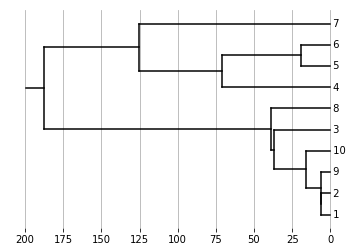



Jukes-Cantor distance matrix for a simulated set of sequences of length L = 50 from the tree leaves: 



Nodes,1,2,3,4,5,6,7,8,9,10
1,0.000000,0.000000,0.020272,0.766238,0.712644,0.712644,0.662626,0.041106,0.000000,0.041106
2,0.000000,0.000000,0.020272,0.766238,0.712644,0.712644,0.662626,0.041106,0.000000,0.041106
3,0.020272,0.020272,0.000000,0.712644,0.662626,0.662626,0.662626,0.020272,0.020272,0.020272
4,0.766238,0.766238,0.712644,0.000000,0.260397,0.205828,0.350505,0.712644,0.766238,0.712644
5,0.712644,0.712644,0.662626,0.260397,0.000000,0.041106,0.383119,0.712644,0.712644,0.662626
6,0.712644,0.712644,0.662626,0.205828,0.041106,0.000000,0.319251,0.712644,0.712644,0.662626
7,0.662626,0.662626,0.662626,0.350505,0.383119,0.319251,0.000000,0.662626,0.662626,0.662626
8,0.041106,0.041106,0.020272,0.712644,0.712644,0.712644,0.662626,0.000000,0.041106,0.041106
9,0.000000,0.000000,0.020272,0.766238,0.712644,0.712644,0.662626,0.041106,0.000000,0.041106
10,0.041106,0.041106,0.020272,0.712644,0.662626,0.662626,0.662626,0.041106,0.041106,0.000000


In [4]:
import numpy as np
import pandas as pd

#This function calculates the Jukes-Cantor distance between two sequences
def jc_distance(s1,s2):
    count = sum(s1[i]!= s2[i] for i in range(len(s1))) #count the number of different sites between s1 and s2
    if count == 0:
        return 0  
    p = min((count/len(s1)),(0.75-1/len(s1))) #p-distance between two sequences so that the distances are well defined
    d = -(3/4)*np.log(1-(4/3)*p) #Jukes-Cantor distance between s1 and s2
    return d

#This function creates the Jukes-Cantor distance matrix
def jc_distance_matrix(sequences):
    distance_matrix = np.zeros(shape=[len(sequences), len(sequences)])
    for i in range(len(sequences)):
        for j in range(len(sequences)):
            distance_matrix[i][j] = (jc_distance(sequences[i],sequences[j]))
    return(distance_matrix)

tree = kingman_tree(10,100) #generate tree for the sequence simulation
jc_sequence_simulation(tree,50,0.0015)
leaves = tree.get_leaves()
leaves = sorted(leaves,key=lambda x: int(x.label)) #order leaves for the matrix input

sequences = list() #create list of sequences
print("Simulated set of sequences of length 50 from the tree leaves:\n")
for leaf in leaves:
    sequences.append(leaf.get_sequence())
    print("node",leaf.get_label(),"sequence:",leaf.get_sequence()) #print simulate set of sequences
    
print("\n\nSimulated Tree with n = 10 leaves and effective population size Ne = 100")
plot_tree(tree)
print("\n\nJukes-Cantor distance matrix for a simulated set of sequences of length L = 50 from the tree leaves: \n")
distance_matrix = jc_distance_matrix(sequences) #Calculate distance_matrix

#print matrix in readable format
df = pd.DataFrame(data = distance_matrix)
df.columns = np.arange(1, len(df)+1)
df.columns.name = "Nodes"
df.index = np.arange(1, len(df)+1)
df

## Simulation with different lengths

We now simulate a tree with n = 10 and Ne = 100. On that tree we simulate
sets of sequences with lengths L = 50, L = 200 and L = 1000, respectively, with
fixed μ = 0.0015. Finally the distance matrices are calculated, the trees are reconstructed using the UPGMA method and the plots are compared to the intial tree simulation

Original simulated tree with n = 10 and Ne = 100:


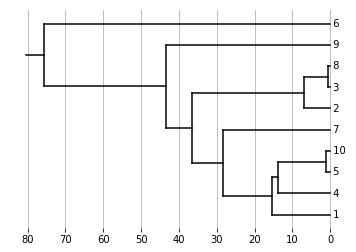


distance matrix for generated sequences of length 50

Nodes        1         2         3         4         5         6         7   \
1      0.000000  0.041106  0.041106  0.000000  0.041106  0.154961  0.041106   
2      0.041106  0.000000  0.000000  0.041106  0.084597  0.179963  0.062536   
3      0.041106  0.000000  0.000000  0.041106  0.084597  0.179963  0.062536   
4      0.000000  0.041106  0.041106  0.000000  0.041106  0.154961  0.041106   
5      0.041106  0.084597  0.084597  0.041106  0.000000  0.205828  0.084597   
6      0.154961  0.179963  0.179963  0.154961  0.205828  0.000000  0.154961   
7      0.041106  0.062536  0.062536  0.041106  0.084597  0.154961  0.000000   
8      0.041106  0.000000  0.000000  0.041106  0.084597  0.179963  0.062536   
9      0.020272  0.041106  0.041106  0.020272  0.062536  0.130765  0.020272   
10     0.041106  0.084597  0.084597  0.041106  0.000000  0.205828  0.084597   

Nodes        8         9         10  
1      0.041106  0.020272  0.041106  

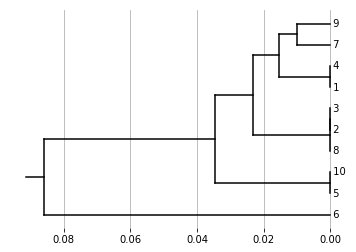


distance matrix for generated sequences of length 200

Nodes        1         2         3         4         5         6         7   \
1      0.000000  0.090215  0.101578  0.015152  0.041106  0.173634  0.073485   
2      0.090215  0.000000  0.010067  0.084597  0.113117  0.173634  0.107326   
3      0.101578  0.010067  0.000000  0.095875  0.124836  0.186346  0.113117   
4      0.015152  0.084597  0.095875  0.000000  0.035843  0.167358  0.067991   
5      0.041106  0.113117  0.124836  0.035843  0.000000  0.199277  0.090215   
6      0.173634  0.173634  0.186346  0.167358  0.199277  0.000000  0.219102   
7      0.073485  0.107326  0.113117  0.067991  0.090215  0.219102  0.000000   
8      0.101578  0.010067  0.000000  0.095875  0.124836  0.186346  0.113117   
9      0.107326  0.113117  0.124836  0.101578  0.124836  0.199277  0.130765   
10     0.051745  0.124836  0.136741  0.046407  0.010067  0.212436  0.101578   

Nodes        8         9         10  
1      0.101578  0.107326  0.051745 

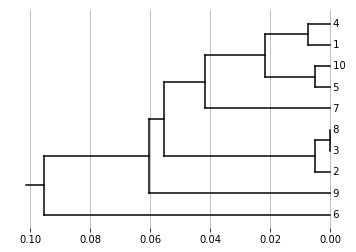


distance matrix for generated sequences of length 1000

Nodes        1         2         3         4         5         6         7   \
1      0.000000  0.097012  0.097012  0.038996  0.042163  0.187629  0.071283   
2      0.097012  0.000000  0.021300  0.086839  0.090215  0.182510  0.086839   
3      0.097012  0.021300  0.000000  0.086839  0.090215  0.185065  0.086839   
4      0.038996  0.086839  0.086839  0.000000  0.030616  0.176159  0.061450   
5      0.042163  0.090215  0.090215  0.030616  0.000000  0.187629  0.067991   
6      0.187629  0.182510  0.185065  0.176159  0.187629  0.000000  0.182510   
7      0.071283  0.086839  0.086839  0.061450  0.067991  0.182510  0.000000   
8      0.097012  0.021300  0.000000  0.086839  0.090215  0.185065  0.086839   
9      0.113117  0.116614  0.115446  0.105021  0.108480  0.188915  0.105021   
10     0.042163  0.090215  0.090215  0.030616  0.000000  0.187629  0.067991   

Nodes        8         9         10  
1      0.097012  0.113117  0.042163

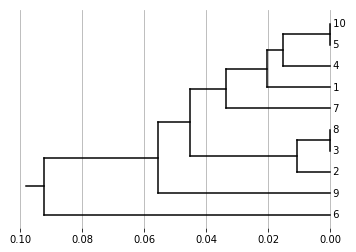

In [5]:
#set parameters and simulate tree
mu = 0.0015
tree = kingman_tree(10, 100)
seq_lengths = [50,200,1000]
sequences = [None]*len(seq_lengths)
distance_matrices = list()

#generate a the list of sequences stored at the leaves for each simulated tree of a given length
for i in range(len(seq_lengths)):
    jc_sequence_simulation(tree,seq_lengths[i],mu)
    leaves = sorted(tree.get_leaves(),key=lambda x: (int(x.label))) #sort leaves from 1 to n
    sequences[i] = list()
    for leaf in leaves:
        sequences[i].append(leaf.get_sequence())
    distance_matrices.append(jc_distance_matrix(sequences[i])) #compute distance matrix and add to the list
    
print("Original simulated tree with n = 10 and Ne = 100:")
plot_tree(tree)

#plot all reconstructed trees using UPGMA method
for i in range(len(seq_lengths)):
    print()
    print("distance matrix for generated sequences of length",seq_lengths[i])
    print()
    df = pd.DataFrame(data = distance_matrices[i])
    df.columns = np.arange(1, len(df)+1)
    df.columns.name = "Nodes"
    df.index = np.arange(1, len(df)+1)
    print(df)
    print("\n\nreconstructed tree with sequence length",seq_lengths[i])
    plot_tree(compute_upgma_tree(distance_matrices[i]))

Although the nodes of each tree are clustered similarly, the distance matrix of Jukes Cantor model does not provide the appropiate data for the UPGMA method to accurately reconstruct the trees.<br>
Jukes Cantor model, for a complex tree, is only correct with p being exact; it only yields correct results when simulating sequences of infinite length. <br><br>
In this simulations, due to the complexity of the tree generated, we can reconstruct a very similar tree to the original one when simulating sequences of length 1000. Therefore we conclude that for a long enough sequence the reconstructed tree and the original tree will match.


## MCMC algorithm to sample the posterior distribution of the effective population size Ne.
We use the tree simulated in the previous step to compute the posterior distribution from a MCMC chain of 10,000 steps
to estimate the population size Ne.
We start by guessing the value for Ne. Then a random walk is performed to estimate the likelihood of a second guess in order to compare them with the metropolis-hasting equation; this is done to achieve the equilibrium distribution for each iteration.

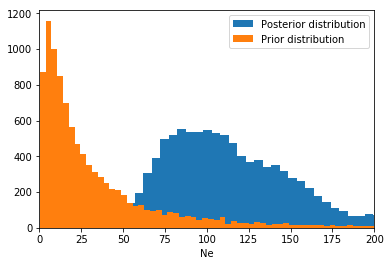

In [6]:
import numpy
import math
from scipy.stats import lognorm
import matplotlib.pyplot as plt


def internal_nodes_heights(node,nodes_heights):
    if not node.is_leaf():
        nodes_heights.append(node.get_height())
        for child in node.get_children():
            internal_nodes_heights(child,nodes_heights)

def mcmc(tree,max_steps,chain):
    ne = 1
    #generate list of times with k linages
    time_linage = list()
    internal_nodes_heights(tree.get_root(),time_linage)
    time_linage.append(0)
    time_linage.sort()
    for i in range(1,len(time_linage)):
        time_linage[i] = (time_linage[i] - time_linage[i-1])
    del time_linage[0]
    time_linage.reverse()
    for i in range(max_steps):
        u = np.random.uniform(-10,10) #random step
        ne2 = ne + u
        if(ne2 > 0): #handle by rejectioon
            likelihood1 = 0
            likelihood2 = 0
            #generate log of the prior probability densities
            prior1 = lognorm.logpdf(ne, s = 1.25,scale=np.exp(3)) 
            prior2 = lognorm.logpdf(ne2, s = 1.25,scale=np.exp(3)) 
            for k in range(2,len(tree.get_leaves())):  #time interval with k linages
                tk = time_linage[k-2]
                b = (k*(k-1)*tk)/(2*ne)
                c = (k*(k-1)*tk)/(2*ne2)
                #compute the coalescent likelihood
                likelihood1 += (-np.log(ne) - b) 
                likelihood2 += (-np.log(ne2) - c)
            #obtain posterior distributions
            post1 = likelihood1 + (prior1) 
            post2 = likelihood2 + (prior2)
            post = post2 - post1
            #compute acceptance probability
            if post > -800 and post < 700: #handle overflow by reject large values
                a = min(1,np.exp(post))
                v = np.random.uniform(0,1)
                if(a > v):
                    ne = ne2
        chain.append(ne) #add to MCMC chain

chain = list() 
priors = np.random.lognormal(3,1.25,10000)
max_steps = 10000
mcmc(tree,max_steps,chain) #generate MCMC chain
#plot histograms
plt.hist(chain, label = "Posterior distribution",bins = "auto")
plt.hist(priors, label = "Prior distribution",bins = "auto")
plt.legend(loc='upper right')
plt.xlabel("Ne")
plt.xlim(0,200)
plt.show()

By plotting the histograms of the posterior distribution of Ne we observe that probability around the true value (Ne = 100) is high. That is, the MCMC algorithm correctly estimates that the true effective population size of the given tree is within the highest posterior density interval.<br>
By comparing with the plot for the prior distribution we can see how much the estimates have been corrected by analyzing the tree structure with our implementation; from a small expected population size to placing the truth within the HPD interval.<br><br>
 
To get a better estimate of the effective population size we can modify the proposal window size and run the MCMC algorithm many times to analyze the convergence of the resulting distributions (the sample distributions should converge as the chains converge to equilibrium). <br>
We need many simulations to generate a sufficient number of parameter samples when too many proposals are rejected. On the other hand accepting too many proposals does not generate relevant information about the distribution.
